
# Double DQN for Overestimation Reduction in Games
## Akhil Avula, Calvin Chang, Daniel Truong
ECE 239AS Spring 2020 \\
Prof.  Lin Yang \\
UCLA, Department of ECE

In [5]:
!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install imageio
!pip install PILLOW
!pip install pyglet
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.10.0)


In [6]:
#connect to Google Colab TPUs
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0
Running on TPU  ['10.77.47.10:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.77.47.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.47.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
#Imports and gym creation
import gym
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Create Gym
from gym import wrappers

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
from tf_agents.agents import DqnAgent
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, atari_preprocessing, suite_atari, atari_wrappers
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
import random

#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam

# TODO: How to test multiple games? List of game names in gym environment, loop
    # through them?

# envCartPole = gym.make('CartPole-v1')
# envCartPole.seed(50)


## Environment

In [8]:
#initialize environment
env_name = 'Alien-v0'

#train_py_env = suite_gym.load(env_name,
                              #gym_env_wrappers=[atari_preprocessing.AtariPreprocessing])

## maybe its the wrapper we're using wtf?


train_py_env = suite_gym.load(env_name,
                             gym_env_wrappers=[atari_preprocessing.AtariPreprocessing, atari_wrappers.FrameStack4])
train_py_env = tf_py_environment.TFPyEnvironment(train_py_env)

eval_py_env = suite_gym.load(env_name,
                             gym_env_wrappers=[atari_preprocessing.AtariPreprocessing, atari_wrappers.FrameStack4])
eval_py_env = tf_py_environment.TFPyEnvironment(eval_py_env)

time_step = train_py_env.reset()
_=eval_py_env.reset()
print(train_py_env.observation_spec())
print(train_py_env.action_spec())

BoundedTensorSpec(shape=(84, 84, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(17))


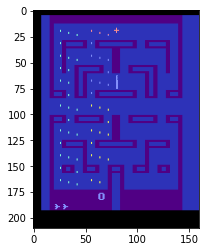

In [32]:
#idk how to render with our wrapper?


env = gym.make('Alien-v0')
render = lambda : plt.imshow(env.render(mode='rgb_array'))
env.reset()
render()

In [30]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

#env = gym.make('Alien-v0')
train_py_env.reset()
for _ in range(100):
    plt.imshow(train_py_env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = train_py_env.action_space.sample()
    train_py_env.step(action)

TypeError: ignored

## Pre-processing?


In [0]:
import cv2
import numpy as np

def process_frame(frame, shape = (84, 84)):
  frame = frame.astype(np.uint8)
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  frame = frame[34:34+160, :160]
  frame = cv2.resize(frame, shape, interpolation=cv2.INTER_NEAREST)
  frame = frame.reshape((*shape, 1))
  return frame

## NN Hyperparameters

In [0]:
# Modify/Set Hyperparameters for NN's 
class hasselt_hyp:
  '''
  Hyperparameters according to DDQN paper from Hasselt et al 2015
  '''
  def __init__(self):
    self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00025,
                                                 momentum=0.95)
    self.num_iterations = 20000
    self.target_update_period = 10000
    self.gamma = 0.99
    self.replay_buffer_max_length = 1000000
    self.collect_steps_per_iteration = 4 
    self.batch_size = 32
    self.log_interval = 20000
    self.num_eval_episodes = 50
    self.eval_interval = 1000000

    #calvin - I'm adding these hyperparams?
    self.epsilon = 0.1
    self.epsilon_decay_period=1000000

In [29]:
env.reset()

print(env.observation_spec())
print(env.action_spec())


AttributeError: ignored

## CNN

In [10]:
#Create qnetwork method (CNN model) and target network https://www.tensorflow.org/agents/api_docs/python/tf_agents/networks/q_network/QNetwork
#From the double q-learning paper:
'''The input to the network is a 84x84x4
tensor containing a rescaled, and gray-scale, version of the last four
frames. The first convolution layer convolves the input with 32 fil-
ters of size 8 (stride 4), the second layer has 64 layers of size 4
(stride 2), the final convolution layer has 64 filters of size 3 (stride
1). This is followed by a fully-connected hidden layer of 512 units.
All these layers are separated by Rectifier Linear Units (ReLu). Fi-
nally, a fully-connected linear layer projects to the output of the
network, i.e., the Q-values. The optimization employed to train the
network is RMSProp (with momentum parameter 0.95).'''

#will inherit input and output shapes from the enviroment param
def hasselt_cnn(env,name='dqn_online'):
  '''
  Returns the q_network parameter specifying the neural network to estimate
  q values. This function recreates the ConvNet from Double Deep Q Networks from
  Hasselt et al 2015. There should be an online and target network for each 
  algorithm implementation
   
  Args:
  env: A tf.agent.environment.wrapper to get input and output tensor shapes for
  name: name of the q network, used purely for labeling purposes
  '''
  conv_layer = [(32, 8, 4), (64, 4, 2), (64, 3, 1)]
  fc_layer = (512,)

  q_net = q_network.QNetwork(
    env.observation_spec(),
    env.action_spec(),
    conv_layer_params=conv_layer,
    fc_layer_params=fc_layer,
    name=name
  )
  return q_net

q = hasselt_cnn(train_py_env,name='dqn_online')
q.create_variables()

ValueError: ignored

## DQN

In [0]:
# Create Decay polynomial https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/polynomial_decay
# Create DQN Model https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent

#example method has no shape error
'''
def example_dqn(train_env):
  fc_layer_params = (100,)

  q_net = q_network.QNetwork(
      train_env.observation_spec(),
      train_env.action_spec(),
      fc_layer_params=fc_layer_params)
  

  example = hasselt_hyp()

  train_step_counter = tf.Variable(0)

  agent = dqn_agent.DqnAgent(
      train_env.time_step_spec(),
      train_env.action_spec(),
      q_network=q_net,
      optimizer=example.optimizer,
      td_errors_loss_fn=common.element_wise_squared_loss,
      train_step_counter=train_step_counter)

  agent.initialize()
  return agent
'''

def double_dqn_hasselt(env, q_net):
  hyperparams = hasselt_hyp()

  epsilon_policy = tf.compat.v1.train.polynomial_decay(
              learning_rate = 1.0,
              global_step = hyperparams.eval_interval,
              decay_steps = hyperparams.epsilon_decay_period / hyperparams.collect_steps_per_iteration,
              end_learning_rate =hyperparams.epsilon
              )

  train_step_counter = tf.Variable(0)

  agent = DqnAgent(

                time_step_spec = env.time_step_spec(), 
                action_spec = env.action_spec(),
                q_network = q_net, 
                optimizer = hyperparams.optimizer,
                epsilon_greedy = epsilon_policy,
                gamma=hyperparams.gamma, 
                #train_step_counter = tf.Variable(0.0)
              
              )
  return agent

print('Observation Spec:')
print(train_py_env.time_step_spec().observation)

print('Reward Spec:')
print(train_py_env.time_step_spec().reward)

print('Action Spec:')
print(train_py_env.action_spec())

#agent2 = example_dqn(train_py_env)

agent = dqn_hasselt(train_py_env, q)
agent.initialize()

Observation Spec:
BoundedTensorSpec(shape=(84, 84, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))
Reward Spec:
TensorSpec(shape=(), dtype=tf.float32, name='reward')
Action Spec:
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(17))


ValueError: ignored

In [0]:
#Metrics and Evaluation? do we need this? only saying this because its in the example LOL

def metrics():
  return metric

In [0]:
#Create Replay Buffer https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial#replay_buffer_api


def Replay_Buffer(agent, env):
  
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agent.collect_data_spec,
      batch_size=env.batch_size,
      max_length=hasselt_hyp().replay_buffer_max_length)
  return replay_buffer

replay_buffer = Replay_Buffer(agent, train_py_env)

#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_py_env, agent.collect_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=hasselt_hyp().batch_size, 
    num_steps=2).prefetch(3)


iterator = iter(dataset)


In [0]:
# Training DQN
#policy
#
#1. replay buffer
#2. data collection/playing episodes/preprocessing the data/bundling up to 4 frames
#3. training
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_py_env.time_step_spec(),
                                                train_py_env.action_spec())

compute_avg_return(eval_py_env, random_policy,)


372.0

In [0]:
agent.collect_policy

In [0]:
try:
  %%time
except:
  pass

train_params = hasselt_hyp()
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_py_env, agent.policy,5)
returns = [avg_return]
print('step = 0: Average Return = {}'.format(avg_return))

for _ in range(train_params.num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(train_params.collect_steps_per_iteration):
    collect_step(train_py_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % 200 == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % 1000 == 0:
    avg_return = compute_avg_return(eval_py_env, agent.policy, 5)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs
step = 0: Average Return = 0.0
step = 200: loss = 622716.625
step = 400: loss = 348608.25
step = 600: loss = 441915.75
step = 800: loss = 373831.25
step = 1000: loss = 62237.15625
step = 1000: Average Return = 0.00
step = 1200: loss = 3618.27734375
step = 1400: loss = 81667.015625
step = 1600: loss = 13956.8125
step = 1800: loss = 7121.41796875
step = 2000: loss = 6043.41015625
step = 2000: Average Return = 0.00
step = 2200: loss = 10152.015625
step = 2400: loss = 8263.419921875
step = 2600: loss = 26786.359375
step = 2800: loss = 17519.65625
step = 3000: loss = 17962.6484375
step = 3000: Average Return = 30.00
step = 3200: loss = 48085.97265625
step = 3400: loss = 7497.72265625
step = 3600: loss = 1014.763916015625
step = 3800: loss = 481.0433349609375
step = 4000: loss = 15959.40234375
step = 4000: Average Return = 100.00
step = 4200: loss = 5944.34765625
step = 4400: loss = 789.6619873046875
step = 4600: loss = 2556.95629

KeyboardInterrupt: ignored

In [0]:
returns

[0.0]

In [0]:
# Testing DQN 

## DDQN

In [0]:
# Create DDQN Model https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/dqn/dqn_agent/DdqnAgent
def ddqn_hasselt(env, q_net):
  hyperparams = ddqn_hyp()

  epsilon_policy = tf.compat.v1.train.polynomial_decay(
              learning_rate = 1.0,
              global_step = hyperparams.eval_interval,
              decay_steps = ddqn_hyp().epsilon_decay_period / ddqn_hyp().collect_steps_per_iteration,
              end_learning_rate = ddqn_hyp().epsilon
              )

  ddqn_agent = tf_agents.agents.dqn.dqn_agent.DdqnAgent(
                time_step_spec = env.time_step_spec().observation, 
                action_spec = env.action_spec(),
                q_network = q_net, 
                optimizer = ddqn_hyp().optimizer,
                observation_and_action_constraint_splitter=None, 
                epsilon_greedy = epsilon_policy,
                n_step_update=1,
                boltzmann_temperature=None, 
                emit_log_probability=False,
                target_q_network=None, 
                target_update_tau=1.0, 
                target_update_period=ddqn_hasselt().target_update_period,
                td_errors_loss_fn=None, 
                gamma=ddqn_hyp().gamma, 
                reward_scale_factor=1.0,
                gradient_clipping=None, 
                debug_summaries=False, 
                summarize_grads_and_vars=False,
                train_step_counter=None, 
                name=None
              )
  return ddqn_agent

In [0]:
# Training DDQN


In [0]:
# Testing DDQN 


## Results

In [0]:
# Plot results
# Overestimations
# NN test results?